# Loan Repayment Prediction 

### Predict if a borrower will pay back their loan using Logistic Regression, Decision tree, Neural Network
### Invastigating the impact of diffrent resampling methods on f1-score

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
import plotly.express as px
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import precision_score

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

%matplotlib inline

In [2]:
data_info = pd.read_csv('lending_club_info.csv',index_col='LoanStatNew')

In [3]:
def feat_info(col_name):
    print(data_info.loc[col_name]['Description'])

In [4]:
df = pd.read_csv('lending_club_loan_two.csv')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396030 entries, 0 to 396029
Data columns (total 27 columns):
loan_amnt               396030 non-null float64
term                    396030 non-null object
int_rate                396030 non-null float64
installment             396030 non-null float64
grade                   396030 non-null object
sub_grade               396030 non-null object
emp_title               373103 non-null object
emp_length              377729 non-null object
home_ownership          396030 non-null object
annual_inc              396030 non-null float64
verification_status     396030 non-null object
issue_d                 396030 non-null object
loan_status             396030 non-null object
purpose                 396030 non-null object
title                   394275 non-null object
dti                     396030 non-null float64
earliest_cr_line        396030 non-null object
open_acc                396030 non-null float64
pub_rec                 396030 non-nu

# Exploratory Data Analysis

In [6]:
rcParams['figure.figsize'] = 7, 5

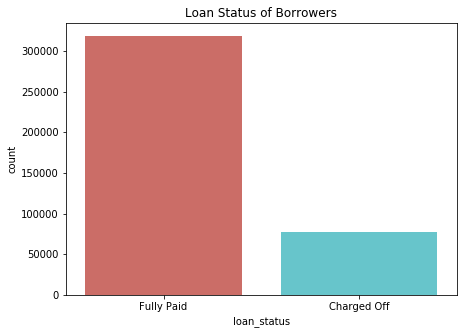

In [7]:
sns.countplot(x=df['loan_status'],palette='hls')
plt.title('Loan Status of Borrowers')
plt.show()


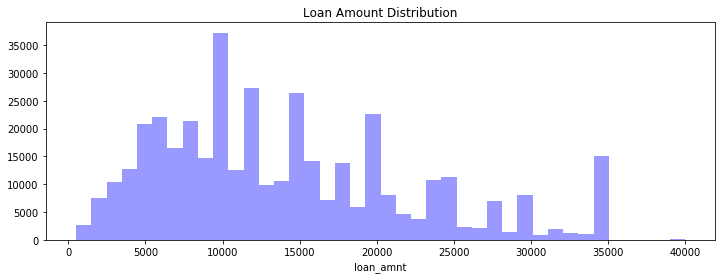

In [8]:
plt.figure(figsize=(12, 4))
sns.distplot(df['loan_amnt'],kde=False,bins=40,color='b')
plt.title('Loan Amount Distribution')
#plt.xkcd()
plt.show()

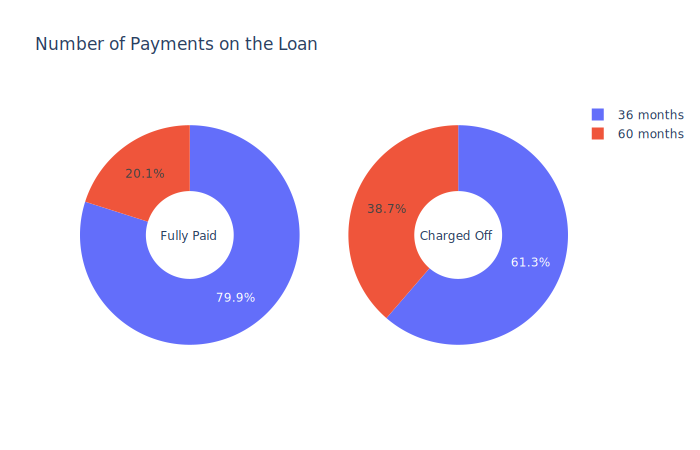

In [9]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio

labels = ["36 months", "60 months"]

# Create subplots: use 'domain' type for Pie subplot
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}]])
fig.add_trace(go.Pie(labels=labels, values=[df[(df['loan_status']=='Fully Paid') & (df['term']==' 36 months')].shape[0],
                                            df[(df['loan_status']=='Fully Paid') & (df['term']==' 60 months')].shape[0]
                                            ], name="Fully Paid"),
              1, 1)
fig.add_trace(go.Pie(labels=labels, values=[df[(df['loan_status']=='Charged Off') & (df['term']==' 36 months')].shape[0],
                                            df[(df['loan_status']=='Charged Off') & (df['term']==' 60 months')].shape[0]
                                            ], name="Charged Off"),
              1, 2)

# Use `hole` to create a donut-like pie chart
fig.update_traces(hole=.4, hoverinfo="label+percent+name")

fig.update_layout(
    title_text="Number of Payments on the Loan",
    # Add annotations in the center of the donut pies.
    annotations=[dict(text='Fully Paid', x=0.16, y=0.5, font_size=12, showarrow=False),
                 dict(text='Charged Off', x=0.85, y=0.5, font_size=12, showarrow=False)])
fig.show(renderer='svg')

In [10]:
# Explore correlation between the continuous feature variables.
df.corr().transpose()

,loan_amnt,int_rate,installment,annual_inc,dti,open_acc,pub_rec,revol_bal,revol_util,total_acc,mort_acc,pub_rec_bankruptcies
loan_amnt,1.000000,0.168921,0.953929,0.336887,0.016636,0.198556,-0.077779,0.328320,0.099911,0.223886,0.222315,-0.106539
int_rate,0.168921,1.000000,0.162758,-0.056771,0.079038,0.011649,0.060986,-0.011280,0.293659,-0.036404,-0.082583,0.057450
installment,0.953929,0.162758,1.000000,0.330381,0.015786,0.188973,-0.067892,0.316455,0.123915,0.202430,0.193694,-0.098628
annual_inc,0.336887,-0.056771,0.330381,1.000000,-0.081685,0.136150,-0.013720,0.299773,0.027871,0.193023,0.236320,-0.050162
dti,0.016636,0.079038,0.015786,-0.081685,1.000000,0.136181,-0.017639,0.063571,0.088375,0.102128,-0.025439,-0.014558
open_acc,0.198556,0.011649,0.188973,0.136150,0.136181,1.000000,-0.018392,0.221192,-0.131420,0.680728,0.109205,-0.027732
pub_rec,-0.077779,0.060986,-0.067892,-0.013720,-0.017639,-0.018392,1.000000,-0.101664,-0.075910,0.019723,0.011552,0.699408
revol_bal,0.328320,-0.011280,0.316455,0.299773,0.063571,0.221192,-0.101664,1.000000,0.226346,0.191616,0.194925,-0.124532
revol_util,0.099911,0.293659,0.123915,0.027871,0.088375,-0.131420,-0.075910,0.226346,1.000000,-0.104273,0.007514,-0.086751
total_acc,0.223886,-0.036404,0.202430,0.193023,0.102128,0.680728,0.019723,0.191616,-0.104273,1.000000,0.381072,0.042035


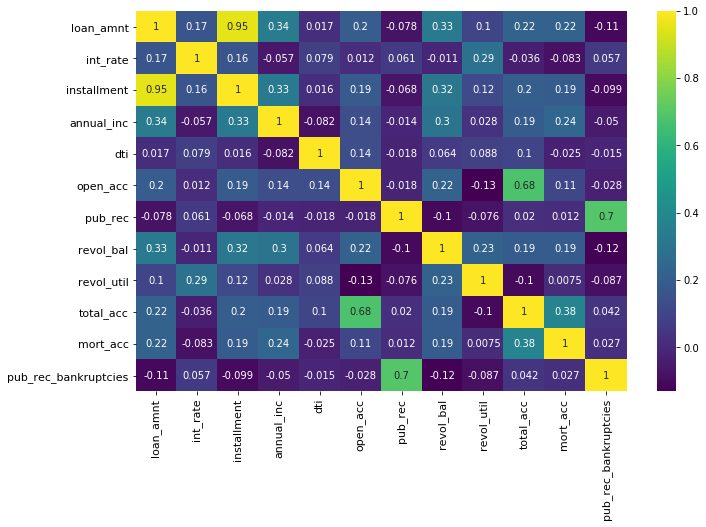

In [11]:
#Finding the most correlate features using a heatmap 
plt.figure(figsize=(11, 7))
ax =sns.heatmap(df.corr(),cmap='viridis',annot=True)
bottom, top = ax.get_ylim()
#Strech out the heatmap
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.show()

In [12]:
feat_info('installment')

The monthly payment owed by the borrower if the loan originates.


In [13]:
feat_info('loan_amnt')

The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.


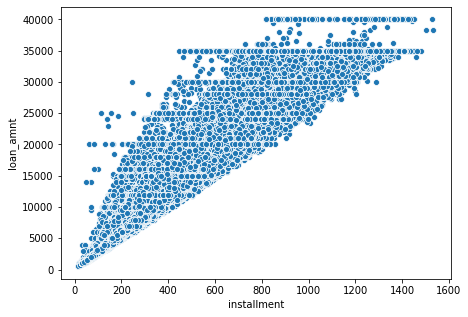

In [14]:
sns.scatterplot(x='installment',y='loan_amnt',data=df)
plt.show()

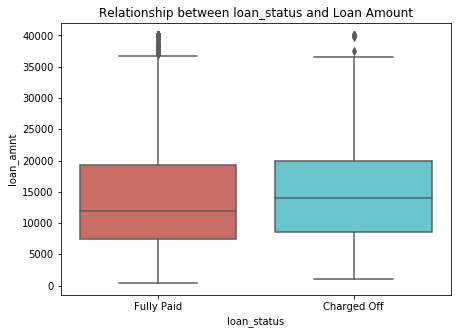

In [15]:
sns.boxplot(x='loan_status',y='loan_amnt',data=df,palette='hls')
plt.title('Relationship between loan_status and Loan Amount')
plt.show()

In [16]:
# Calculate the summary statistics for the loan amount, grouped by the loan_status
df.groupby('loan_status').describe()['loan_amnt']

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,77673.0,15126.300967,8505.090557,1000.0,8525.0,14000.0,20000.0,40000.0
Fully Paid,318357.0,13866.878771,8302.319699,500.0,7500.0,12000.0,19225.0,40000.0


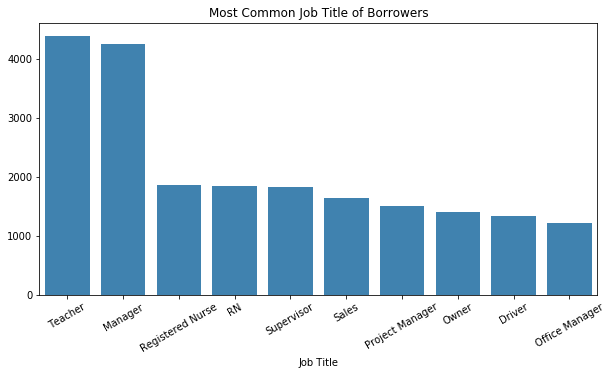

In [17]:
top10_job = df['emp_title'].value_counts().head(10)
plt.figure(figsize=(10,5))
sns.barplot(x=top10_job.index , y=top10_job.values, color='#2E86C1')
plt.title('Most Common Job Title of Borrowers')
plt.xticks(rotation='30')
plt.xlabel('Job Title',size=10)
plt.show()

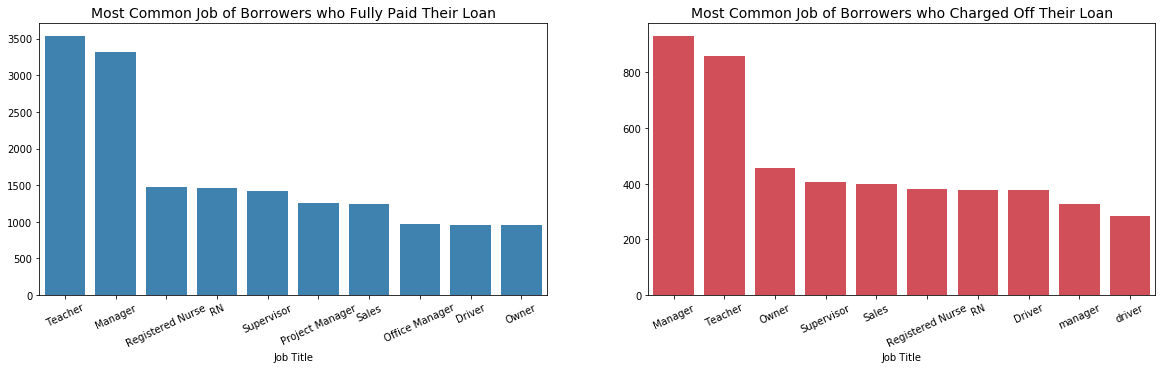

In [18]:
#Findinf the most common jobs of borrowers who fully paid their loan
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
top10_job_1 = df[df['loan_status']=='Fully Paid']['emp_title'].value_counts().head(10)
sns.barplot(x=top10_job_1.index , y=top10_job_1.values, color='#2E86C1')
plt.title('Most Common Job of Borrowers who Fully Paid Their Loan',size=14)
plt.xticks(rotation='25')
plt.xlabel('Job Title',size=10)

#Findinf the most common jobs of borrowers who charged off their loan
plt.subplot(1,2,2)
top10_job_0 = df[df['loan_status']=='Charged Off']['emp_title'].value_counts().head(10)
sns.barplot(x=top10_job_0.index , y=top10_job_0.values, color='#E63946')
plt.title('Most Common Job of Borrowers who Charged Off Their Loan',size=14)
plt.xticks(rotation='25')
plt.xlabel('Job Title',size=10)

plt.show()

In [19]:
top10_job.index

Index(['Teacher', 'Manager', 'Registered Nurse', 'RN', 'Supervisor', 'Sales',
       'Project Manager', 'Owner', 'Driver', 'Office Manager'],
      dtype='object')

In [20]:
df_top_10_jobs = df[(df['emp_title']=='Teacher') | (df['emp_title']=='Manager') 
   | (df['emp_title']=='Registered Nurse') | (df['emp_title']=='RN')
  | (df['emp_title']=='Supervisor') | (df['emp_title']=='Sales')
  |(df['emp_title']=='Project Manager') | (df['emp_title']=='Owner')
  |(df['emp_title']=='Driver') | (df['emp_title']=='Office Manager')]


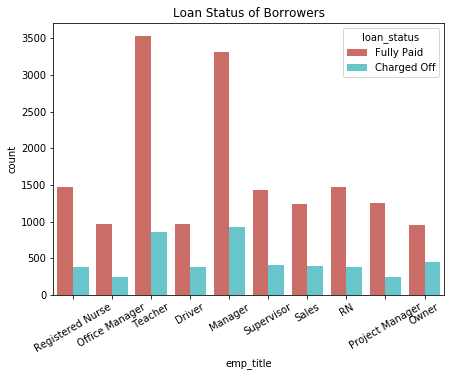

In [21]:
sns.countplot(x='emp_title',data=df_top_10_jobs, hue='loan_status',palette='hls')
plt.title('Loan Status of Borrowers')
plt.xticks(rotation='30')
plt.show()

,Borrower with Different Type of Application
INDIVIDUAL,395319
JOINT,425
DIRECT_PAY,286


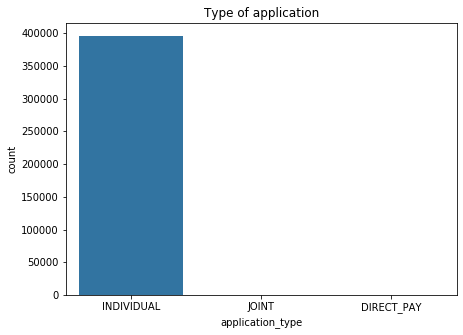

In [22]:
sns.countplot(x='application_type',data=df)
plt.title('Type of application')
application_type_data = [df[df['application_type']=='INDIVIDUAL'].shape[0],
                        df[df['application_type']=='JOINT'].shape[0],
                        df[df['application_type']=='DIRECT_PAY'].shape[0]]
pd.DataFrame(data=application_type_data, index=['INDIVIDUAL','JOINT','DIRECT_PAY'],columns=['Borrower with Different Type of Application'])

In [23]:
set(df['grade'])

{'A', 'B', 'C', 'D', 'E', 'F', 'G'}

In [24]:
df['sub_grade'].unique()

array(['B4', 'B5', 'B3', 'A2', 'C5', 'C3', 'A1', 'B2', 'C1', 'A5', 'E4',
       'A4', 'A3', 'D1', 'C2', 'B1', 'D3', 'D5', 'D2', 'E1', 'E2', 'E5',
       'F4', 'E3', 'D4', 'G1', 'F5', 'G2', 'C4', 'F1', 'F3', 'G5', 'G4',
       'F2', 'G3'], dtype=object)

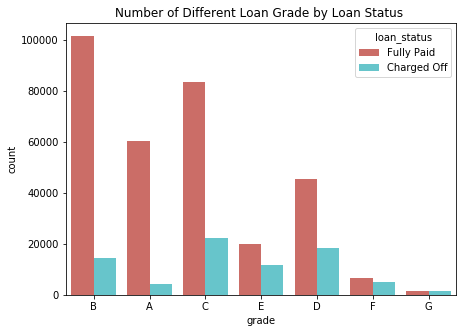

In [25]:
sns.countplot(x='grade',hue='loan_status',data=df,palette='hls')
plt.title('Number of Different Loan Grade by Loan Status ')
plt.show()

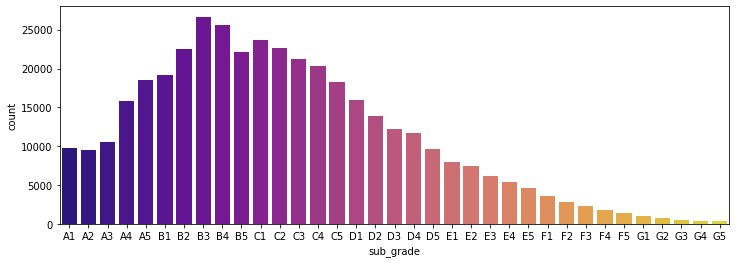

In [26]:
plt.figure(figsize=(12,4))
sns.countplot(x='sub_grade',data=df,palette='plasma',order=['A1',
 'A2','A3','A4','A5','B1','B2','B3','B4','B5','C1','C2','C3','C4','C5','D1','D2','D3',
 'D4','D5','E1','E2','E3','E4','E5','F1','F2','F3','F4','F5','G1','G2','G3','G4','G5'])
plt.show()

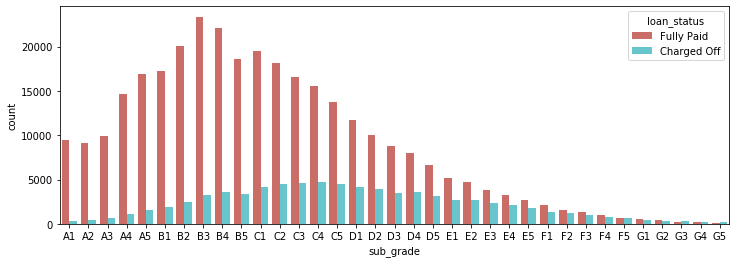

In [27]:
plt.figure(figsize=(12,4))
sns.countplot(x='sub_grade',data=df,palette='hls',order=sorted(df['sub_grade'].unique()), hue='loan_status')
plt.show()

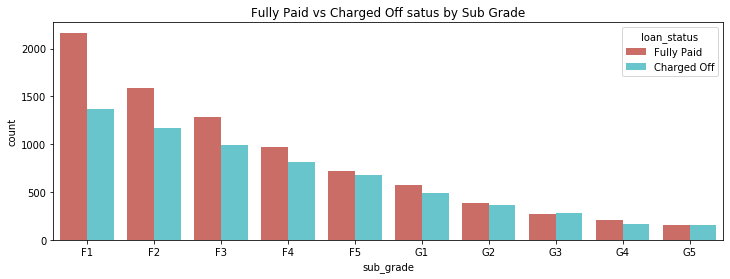

In [28]:
#Zoom in
plt.figure(figsize=(12,4))
sns.countplot(x='sub_grade',data=df,palette='hls',order=sorted(df['sub_grade'].unique())[-10:], hue='loan_status')
plt.title('Fully Paid vs Charged Off satus by Sub Grade')
plt.show()

In [29]:
# One-hot encoder

In [30]:
df['loan_repaid']= pd.get_dummies(df['loan_status'],drop_first=True)

In [31]:
df[['loan_repaid','loan_status']]

,loan_repaid,loan_status
0,1,Fully Paid
1,1,Fully Paid
2,1,Fully Paid
3,1,Fully Paid
4,0,Charged Off
...,...,...
396025,1,Fully Paid
396026,1,Fully Paid
396027,1,Fully Paid
396028,1,Fully Paid


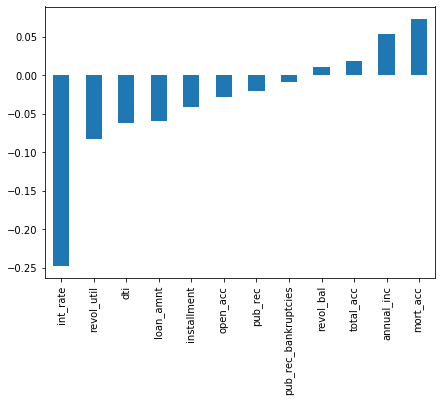

In [32]:
df.corr()['loan_repaid'].drop('loan_repaid').sort_values().plot(kind='bar')
plt.show()

# Data PreProcessing

# Missing Data

In [33]:
df.isnull().sum()

loan_amnt                   0
term                        0
int_rate                    0
installment                 0
grade                       0
sub_grade                   0
emp_title               22927
emp_length              18301
home_ownership              0
annual_inc                  0
verification_status         0
issue_d                     0
loan_status                 0
purpose                     0
title                    1755
dti                         0
earliest_cr_line            0
open_acc                    0
pub_rec                     0
revol_bal                   0
revol_util                276
total_acc                   0
initial_list_status         0
application_type            0
mort_acc                37795
pub_rec_bankruptcies      535
address                     0
loan_repaid                 0
dtype: int64

In [34]:
# Define a function to show null value percentage of each feature

In [35]:
def nullPercentage(data):
    for i in df.columns:
        percent = df[i].isnull().sum() / df.shape[0] * 100
        if percent != 0:
            print('{} : {}% null values'.format(i,np.round(percent,2)))
nullPercentage(df)

emp_title : 5.79% null values
emp_length : 4.62% null values
title : 0.44% null values
revol_util : 0.07% null values
mort_acc : 9.54% null values
pub_rec_bankruptcies : 0.14% null values


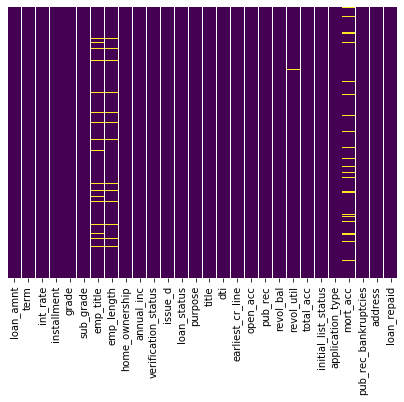

In [36]:
sns.heatmap(df.isnull(),cmap='viridis',cbar=False,yticklabels=False)

In [37]:
feat_info('emp_title')

The job title supplied by the Borrower when applying for the loan.*


In [38]:
# Unique employment job titles
df['emp_title'].unique().shape[0]

173106

In [39]:
# Too many unique job titles to convert it to dummy variables. So we remove the emp_title column.
df=df.drop('emp_title',axis=1)

In [40]:
emp_title_order= ['< 1 year','1 year','2 years','3 years','4 years','5 years','6 years',
 '7 years','8 years','9 years','10+ years',]

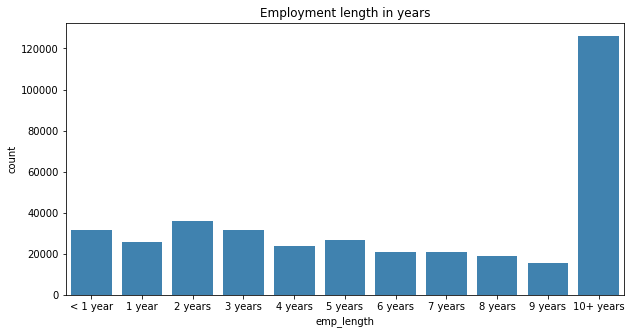

In [41]:
plt.figure(figsize=(10,5))
sns.countplot(x='emp_length',data=df,order=emp_title_order,color='#2E86C1')
plt.title('Employment length in years',size=12)
plt.show()

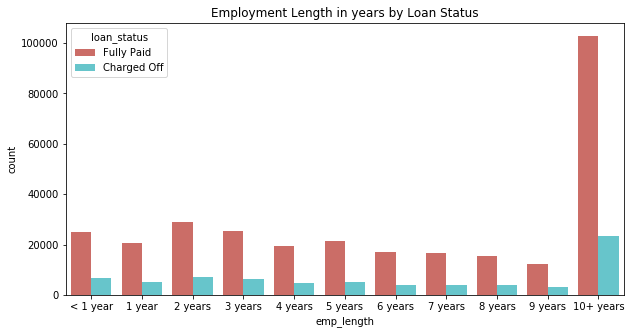

In [42]:
plt.figure(figsize=(10,5))
sns.countplot(x='emp_length',data=df,order=emp_title_order,palette='hls',hue='loan_status')
plt.title('Employment Length in years by Loan Status',size=12)
plt.show()

In [43]:
# Finding percentage of charge offs per category

In [44]:
emp_length_df_1= df[df['loan_status']=='Fully Paid'].groupby('emp_length').count()['loan_status']

In [45]:
emp_length_df_0= df[df['loan_status']=='Charged Off'].groupby('emp_length').count()['loan_status']

In [46]:
series = pd.Series(data=emp_length_df_0.values/(emp_length_df_1.values+emp_length_df_0.values),index=emp_length_df_0.index)

In [47]:
series

emp_length
1 year       0.199135
10+ years    0.184186
2 years      0.193262
3 years      0.195231
4 years      0.192385
5 years      0.192187
6 years      0.189194
7 years      0.194774
8 years      0.199760
9 years      0.200470
< 1 year     0.206872
dtype: float64

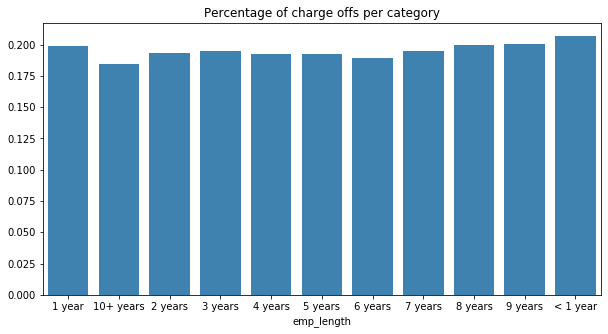

In [48]:
plt.figure(figsize=(10,5))
sns.barplot(x=series.index,y=series.values,color='#2E86C1')
plt.title('Percentage of charge offs per category',size=12)
plt.show()

In [49]:
#Similar charge off rates across all employment lengths, remove the emp_length column
df = df.drop('emp_length',axis=1)

In [50]:
nullPercentage(df)

title : 0.44% null values
revol_util : 0.07% null values
mort_acc : 9.54% null values
pub_rec_bankruptcies : 0.14% null values


In [51]:
# title column and the purpose column are simmilar
print(df['title'].head(3))
print(df['purpose'].head(3))

0                   Vacation
1         Debt consolidation
2    Credit card refinancing
Name: title, dtype: object
0              vacation
1    debt_consolidation
2           credit_card
Name: purpose, dtype: object


In [52]:
df = df.drop('title',axis=1)

In [53]:
nullPercentage(df)

revol_util : 0.07% null values
mort_acc : 9.54% null values
pub_rec_bankruptcies : 0.14% null values


In [54]:
feat_info('mort_acc')

Number of mortgage accounts.


In [55]:
df['mort_acc'].value_counts()

0.0     139777
1.0      60416
2.0      49948
3.0      38049
4.0      27887
5.0      18194
6.0      11069
7.0       6052
8.0       3121
9.0       1656
10.0       865
11.0       479
12.0       264
13.0       146
14.0       107
15.0        61
16.0        37
17.0        22
18.0        18
19.0        15
20.0        13
24.0        10
22.0         7
21.0         4
25.0         4
27.0         3
23.0         2
32.0         2
26.0         2
31.0         2
30.0         1
28.0         1
34.0         1
Name: mort_acc, dtype: int64

9.54% of mort_acc column are missing values. We should replae them instead of removing them. 

In [56]:
df.corr()['mort_acc'].index

Index(['loan_amnt', 'int_rate', 'installment', 'annual_inc', 'dti', 'open_acc',
       'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'mort_acc',
       'pub_rec_bankruptcies', 'loan_repaid'],
      dtype='object')

In [57]:
pd.Series(data=(df.corr()['mort_acc'])).drop('mort_acc').sort_values()

int_rate               -0.082583
dti                    -0.025439
revol_util              0.007514
pub_rec                 0.011552
pub_rec_bankruptcies    0.027239
loan_repaid             0.073111
open_acc                0.109205
installment             0.193694
revol_bal               0.194925
loan_amnt               0.222315
annual_inc              0.236320
total_acc               0.381072
Name: mort_acc, dtype: float64

Number of mortgage accounts.
The total number of credit lines currently in the borrower's credit file
None None


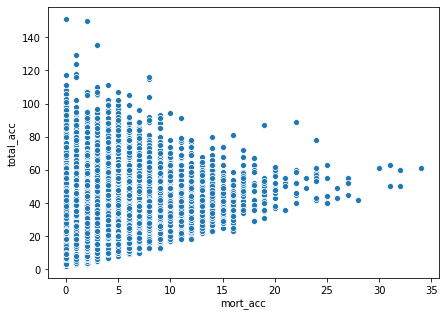

In [58]:
print(feat_info('mort_acc'),feat_info('total_acc'))
sns.scatterplot(x= 'mort_acc', y='total_acc',data=df)
plt.show()

### Create a LinearRegression model to fill missing values of mort_acc

In [59]:
from sklearn.linear_model import LinearRegression

In [60]:
#loan_amnt, annual_inc
nan_mort_total_df = df[df['mort_acc'].isnull()][['mort_acc','total_acc','loan_amnt','annual_inc']]
not_nan_mort_total_df = df[df['mort_acc'].notnull()][['mort_acc','total_acc','loan_amnt','annual_inc']]

In [61]:
X_train= np.array(not_nan_mort_total_df['total_acc']).reshape(-1, 1)
y_train= np.array(not_nan_mort_total_df['mort_acc']).reshape(-1, 1)

X_test = np.array(nan_mort_total_df['total_acc']).reshape(-1, 1)

In [62]:
lm = LinearRegression()

In [63]:
lm.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [64]:
predictions = lm.predict(X_test)

In [65]:
df['mort_acc2']=df['mort_acc']

In [66]:
index = df[df['mort_acc'].isnull()]['mort_acc'].index

In [67]:
predictions[0]

array([0.52306809])

In [68]:
import warnings
warnings.filterwarnings("ignore")
for i,index in enumerate(index):
    df['mort_acc2'].iloc[index]= predictions[i]

In [69]:
df = df.drop('mort_acc',axis=1)

In [70]:
nullPercentage(df)

revol_util : 0.07% null values
pub_rec_bankruptcies : 0.14% null values


In [71]:
# Drop the rest

In [72]:
df= df.dropna()

In [73]:
nullPercentage(df)

# PreProcessing Categorical Variables

In [74]:
type_series = df.dtypes

In [75]:
list(df.select_dtypes(include=['object']))

['term',
 'grade',
 'sub_grade',
 'home_ownership',
 'verification_status',
 'issue_d',
 'loan_status',
 'purpose',
 'earliest_cr_line',
 'initial_list_status',
 'application_type',
 'address']

In [76]:
df['term']=df['term'].apply(lambda x: 36 if x==' 36 months' else 60)

### grade feature
grade is part of sub_grade, drop the grade feature

In [77]:
df= df.drop('grade',axis=1)

In [78]:
#Convert the subgrade into dummy variables
dummies = pd.get_dummies(df['sub_grade'],drop_first=True)
df= pd.concat( [df.drop('sub_grade',axis=1),dummies],axis=1)

In [79]:
list(df.select_dtypes(include=['object']))

['home_ownership',
 'verification_status',
 'issue_d',
 'loan_status',
 'purpose',
 'earliest_cr_line',
 'initial_list_status',
 'application_type',
 'address']

In [80]:
dummies3 = pd.get_dummies(df['application_type'],drop_first=True)
df= pd.concat( [df.drop('application_type',axis=1),dummies3],axis=1)

In [81]:
dummies4 = pd.get_dummies(df['initial_list_status'],drop_first=True)
df= pd.concat( [df.drop('initial_list_status',axis=1),dummies4],axis=1)

In [82]:
dummies5 = pd.get_dummies(df['purpose'],drop_first=True)
df= pd.concat( [df.drop('purpose',axis=1),dummies5],axis=1)

In [83]:
dummies7 = pd.get_dummies(df['verification_status'],drop_first=True)
df= pd.concat( [df.drop('verification_status',axis=1),dummies7],axis=1)


In [84]:
list(df.select_dtypes(include=['object']))

['home_ownership', 'issue_d', 'loan_status', 'earliest_cr_line', 'address']

### home_ownership

In [85]:
df['home_ownership'].value_counts()

MORTGAGE    198022
RENT        159395
OWN          37660
OTHER          110
NONE            29
ANY              3
Name: home_ownership, dtype: int64

In [86]:
df['home_ownership']=df['home_ownership'].replace(['NONE','ANY'],'OTHER')

In [87]:
df['home_ownership'].value_counts()

MORTGAGE    198022
RENT        159395
OWN          37660
OTHER          142
Name: home_ownership, dtype: int64

In [88]:
dummies7 = pd.get_dummies(df['home_ownership'],drop_first=True)
df= pd.concat( [df.drop('home_ownership',axis=1),dummies7],axis=1)

### address
Extract xip_code

In [89]:
df['address'].head()

0       0174 Michelle Gateway\nMendozaberg, OK 22690
1    1076 Carney Fort Apt. 347\nLoganmouth, SD 05113
2    87025 Mark Dale Apt. 269\nNew Sabrina, WV 05113
3              823 Reid Ford\nDelacruzside, MA 00813
4               679 Luna Roads\nGreggshire, VA 11650
Name: address, dtype: object

In [90]:
df['zip_code']=df['address'].apply(lambda x: x[-5:])

In [91]:
df['zip_code'].unique()

array(['22690', '05113', '00813', '11650', '30723', '70466', '29597',
       '48052', '86630', '93700'], dtype=object)

In [92]:
dummies6 = pd.get_dummies(df['zip_code'],drop_first=True)
df= pd.concat( [df.drop('zip_code',axis=1),dummies6],axis=1)

In [93]:
df=df.drop('address',axis=1)

### issue_d 
Data leakage, drop this feature

In [94]:
df=df.drop('issue_d',axis=1)

### earliest_cr_line
Keep the year

In [95]:
list(df.select_dtypes(include=['object']))

['loan_status', 'earliest_cr_line']

In [96]:
df['earliest_cr_year'] = df['earliest_cr_line'].apply(lambda date:int(date[-4:]))
df = df.drop('earliest_cr_line',axis=1)

## Train and Test Split

In [97]:
df = df.drop('loan_status',axis=1)

In [98]:
df.columns

Index(['loan_amnt', 'term', 'int_rate', 'installment', 'annual_inc', 'dti',
       'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'pub_rec_bankruptcies', 'loan_repaid', 'mort_acc2', 'A2', 'A3', 'A4',
       'A5', 'B1', 'B2', 'B3', 'B4', 'B5', 'C1', 'C2', 'C3', 'C4', 'C5', 'D1',
       'D2', 'D3', 'D4', 'D5', 'E1', 'E2', 'E3', 'E4', 'E5', 'F1', 'F2', 'F3',
       'F4', 'F5', 'G1', 'G2', 'G3', 'G4', 'G5', 'INDIVIDUAL', 'JOINT', 'w',
       'credit_card', 'debt_consolidation', 'educational', 'home_improvement',
       'house', 'major_purchase', 'medical', 'moving', 'other',
       'renewable_energy', 'small_business', 'vacation', 'wedding',
       'Source Verified', 'Verified', 'OTHER', 'OWN', 'RENT', '05113', '11650',
       '22690', '29597', '30723', '48052', '70466', '86630', '93700',
       'earliest_cr_year'],
      dtype='object')

In [99]:
df_sample = df.sample(frac=0.5,random_state=101)
#X = df_sample.drop(['loan_repaid'],axis=1).values
#y=df_sample['loan_repaid'].values
X= df.drop(['loan_repaid'],axis=1)
y= df['loan_repaid']

#X= df_test_over.drop(['loan_repaid'],axis=1).values
#y= df_test_over['loan_repaid'].values

In [100]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

As you can see from the graph below, we are dealing with an imbalanced dataset. 
Actually 80 percent of the data points are labeled as Fully Paid. Therefore, a simple model can predict the number of fully paid loans with 80 percent accuracy. 

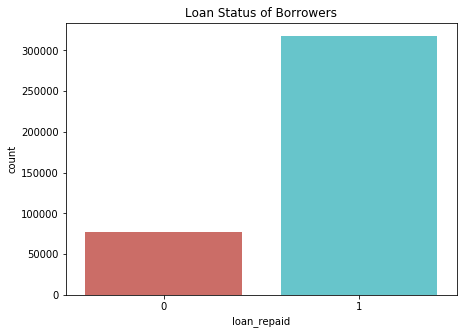

In [101]:
sns.countplot(x=df['loan_repaid'],palette='hls')
plt.title('Loan Status of Borrowers')
plt.show()

By building our predictive models based on imbalanced dataset, the model performance won't be satisfactory, because the model is not trained on a sufficient amount of data representing not fully paid loans.

Therefore, we want to use a common strategy to overcome the class imbalance problem and resample the training dataset.

# Different resampling methods to deal with imbalanced dataset

## Random Under Sampling

In [102]:
df_train = X_train.copy()

In [103]:
df_train ['loan_repaid']=y_train

In [104]:
# Class count
count_class_1, count_class_0 = df_train['loan_repaid'].value_counts()

In [105]:
# Divide by class
df_class_0 = df_train[df_train['loan_repaid'] == 0]
df_class_1 = df_train[df_train['loan_repaid'] == 1]

Random under-sampling:
1    61865
0    61865
Name: loan_repaid, dtype: int64


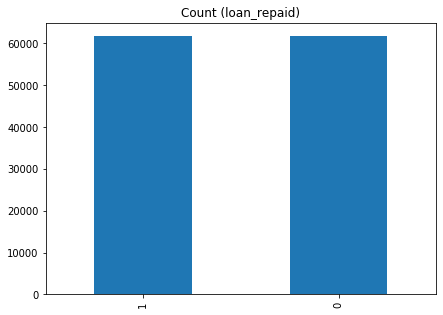

In [106]:
df_class_1_under = df_class_1.sample(count_class_0)
df_test_under = pd.concat([df_class_1_under, df_class_0], axis=0)

print('Random under-sampling:')
print(df_test_under['loan_repaid'].value_counts())

df_test_under['loan_repaid'].value_counts().plot(kind='bar', title='Count (loan_repaid)');

In [107]:
X_train_rus = df_test_under.drop('loan_repaid',axis=1)
y_train_rus = df_test_under['loan_repaid']

## Random over-sampling

In [108]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler()
X_ros, y_ros = ros.fit_sample(X_train, y_train)

## Over-sampling: SMOTE

In [109]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=12)
X_train_sm, y_train_sm = sm.fit_sample(X_train, y_train)

## Over-sampling followed by under-sampling (using SMOTE and Tomek links techniques)

In [110]:
from imblearn.combine import SMOTETomek

smt = SMOTETomek()
X_train_smt, y_train_smt = smt.fit_sample(X_train, y_train)

In [111]:
print(X_train.shape)
print(X_ros.shape)
print(X_train_sm.shape)
print(X_train_smt.shape)

(316175, 78)
(508620, 78)
(508620, 78)
(466694, 78)


In [112]:
# Defining a function to store evaluation metrics
def evaluate(prediction): 
    result = classification_report(y_test,prediction,output_dict=True)
    f1 = result['0']['f1-score']
    accuracy = result['accuracy']
    performance_data= {'f1-score':round(f1, 2),
                      'accuracy':round(accuracy, 2)}
    return performance_data

## Logistic Regression

In [113]:
from sklearn.linear_model import LogisticRegression

In [114]:
def logistic_reg(X_train,y_train):
    logModel = LogisticRegression()
    logModel.fit(X_train,y_train)
    log_predictions = logModel.predict(X_test)
    lr_result = evaluate(log_predictions)
    y_score = logModel.predict_proba(X_test)[:,1]
    return confusion_matrix(y_test,log_predictions),lr_result,y_score

In [115]:
lr_cm ,lr_result,y_score= logistic_reg(X_train,y_train)
print(lr_result)
print(lr_cm)
print('ROC AUC=%.3f' % roc_auc_score(y_test, y_score))

{'f1-score': 0.1, 'accuracy': 0.8}
[[  852 14806]
 [  758 62628]]
ROC AUC=0.688


In [116]:
lr_cm_rus ,lr_result_rus,y_score_rus = logistic_reg(X_train_rus,y_train_rus)
print(lr_result_rus)
print(lr_cm_rus)
print('ROC AUC=%.3f' % roc_auc_score(y_test, y_score_rus))

{'f1-score': 0.41, 'accuracy': 0.64}
[[ 9668  5990]
 [22236 41150]]
ROC AUC=0.686


In [117]:
lr_cm_ros ,lr_result_ros,y_score_ros = logistic_reg(X_ros,y_ros)
print(lr_result_ros)
print(lr_cm_ros)
print('ROC AUC=%.3f' % roc_auc_score(y_test, y_score_ros))

{'f1-score': 0.37, 'accuracy': 0.61}
[[ 9158  6500]
 [24133 39253]]
ROC AUC=0.645


In [118]:
lr_cm_sm ,lr_result_sm ,y_score_sm= logistic_reg(X_train_sm,y_train_sm)
print(lr_result_sm)
print(lr_cm_sm)
print('ROC AUC=%.3f' % roc_auc_score(y_test, y_score_sm))

{'f1-score': 0.37, 'accuracy': 0.59}
[[ 9452  6206]
 [26042 37344]]
ROC AUC=0.636


In [119]:
lr_cm_smt ,lr_result_smt, y_score_smt= logistic_reg(X_train_smt,y_train_smt)
print(lr_result_smt)
print(lr_cm_smt)
print('ROC AUC=%.3f' % roc_auc_score(y_test, y_score_smt))

{'f1-score': 0.41, 'accuracy': 0.65}
[[ 9489  6169]
 [21355 42031]]
ROC AUC=0.688


## Decision Tree

In [120]:
from sklearn.tree import DecisionTreeClassifier

In [121]:
def decision_tree(X_train,y_train):
    dtree = DecisionTreeClassifier()
    dtree.fit(X_train,y_train)
    dt_prediction = dtree.predict(X_test)
    dtree_result = evaluate(dt_prediction)
    return confusion_matrix(y_test,dt_prediction),dtree_result

In [122]:
dtree_cm, dtree_result = decision_tree(X_train,y_train)
print(dtree_result)
print(dtree_cm)

{'f1-score': 0.58, 'accuracy': 0.83}
[[ 9303  6355]
 [ 7093 56293]]


In [123]:
dtree_cm_rus, dtree_result_rus = decision_tree(X_train_rus,y_train_rus)
print(dtree_result_rus)
print(dtree_cm_rus)

{'f1-score': 0.54, 'accuracy': 0.74}
[[11646  4012]
 [16172 47214]]


In [124]:
dtree_cm_ros, dtree_result_ros = decision_tree(X_ros,y_ros)
print(dtree_result_ros)
print(dtree_cm_ros)

{'f1-score': 0.58, 'accuracy': 0.83}
[[ 9116  6542]
 [ 6673 56713]]


In [125]:
dtree_cm_sm, dtree_result_sm = decision_tree(X_train_sm,y_train_sm)
print(dtree_result_sm)
print(dtree_cm_sm)

{'f1-score': 0.57, 'accuracy': 0.82}
[[ 9374  6284]
 [ 7818 55568]]


In [126]:
dtree_cm_smt, dtree_result_smt = decision_tree(X_train_smt,y_train_smt)
print(dtree_result_smt)
print(dtree_cm_smt)

{'f1-score': 0.57, 'accuracy': 0.82}
[[ 9371  6287]
 [ 7772 55614]]


## Random Forest Classifier

In [127]:
from sklearn.ensemble import RandomForestClassifier

In [128]:
def random_forest(X_train,y_train):
    rf = RandomForestClassifier(n_estimators=100)
    rf.fit(X_train,y_train)
    rf_prediction = rf.predict(X_test)
    rf_result = evaluate(rf_prediction)
    return confusion_matrix(y_test,rf_prediction),rf_result

In [129]:
rf_cm, rf_result = random_forest(X_train_smt,y_train_smt)
print(rf_result)
print(rf_cm)

{'f1-score': 0.62, 'accuracy': 0.88}
[[ 7555  8103]
 [ 1350 62036]]


In [130]:
rf_cm_rus, rf_result_rus = random_forest(X_train_rus,y_train_rus)
print(rf_result_rus)
print(rf_cm_rus)

{'f1-score': 0.61, 'accuracy': 0.8}
[[12143  3515]
 [12265 51121]]


In [131]:
rf_cm_ros, rf_result_ros = random_forest(X_ros,y_ros)
print(rf_result_ros)
print(rf_cm_ros)

{'f1-score': 0.64, 'accuracy': 0.89}
[[ 7845  7813]
 [ 1201 62185]]


In [132]:
rf_cm_sm, rf_result_sm = random_forest(X_train_sm,y_train_sm)
print(rf_result_sm)
print(rf_cm_sm)

{'f1-score': 0.62, 'accuracy': 0.88}
[[ 7558  8100]
 [ 1339 62047]]


In [133]:
rf_cm_smt, rf_result_smt = random_forest(X_train_smt,y_train_smt)
print(rf_result_smt)
print(rf_cm_smt)

{'f1-score': 0.61, 'accuracy': 0.88}
[[ 7583  8075]
 [ 1484 61902]]


# Neural Network

In [134]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler

In [135]:
def neural_network(X_train,y_train,X_test,y_test):
    
    X_train = X_train.values
    y_train = y_train.values
    X_test= X_test.values
    y_test = y_test.values
    #Scale the data
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    model = Sequential()

    model.add(Dense(78,  activation='relu'))
    model.add(Dropout(0.2))

    model.add(Dense(39, activation='relu'))
    model.add(Dropout(0.2))

    model.add(Dense(19, activation='relu'))
    model.add(Dropout(0.2))

    model.add(Dense(units=1,activation='sigmoid'))

    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam')
    
    early_stop= EarlyStopping(monitor='val_loss',mode = 'auto',verbose=1,patience=25)

    model.fit(x=X_train, 
          y=y_train, 
          epochs=25,
          batch_size=256,
          validation_data=(X_test, y_test),callbacks=[early_stop]
          )
    
    
    #Evaluate the Model
    losses = pd.DataFrame(model.history.history)
    
    
    predictions = model.predict_classes(X_test)
    
    nn_result = evaluate(predictions)
    
    
    return confusion_matrix(y_test,predictions),nn_result,losses

In [136]:
nn_cm, nn_result,losses= neural_network(X_train,y_train,X_test,y_test)

Train on 316175 samples, validate on 79044 samples
Epoch 1/25
316175/316175 [==============================] - 5s 16us/sample - loss: 0.2999 - val_loss: 0.2643
Epoch 2/25
316175/316175 [==============================] - 4s 12us/sample - loss: 0.2654 - val_loss: 0.2625
Epoch 3/25
316175/316175 [==============================] - 4s 14us/sample - loss: 0.2627 - val_loss: 0.2626
Epoch 4/25
316175/316175 [==============================] - 3s 11us/sample - loss: 0.2616 - val_loss: 0.2618
Epoch 5/25
316175/316175 [==============================] - 3s 11us/sample - loss: 0.2607 - val_loss: 0.2621
Epoch 6/25
316175/316175 [==============================] - 4s 11us/sample - loss: 0.2602 - val_loss: 0.2617
Epoch 7/25
316175/316175 [==============================] - 4s 11us/sample - loss: 0.2595 - val_loss: 0.2616
Epoch 8/25
316175/316175 [==============================] - 4s 12us/sample - loss: 0.2595 - val_loss: 0.2613
Epoch 9/25
316175/316175 [==============================] - 5s 15us/sample - 

{'f1-score': 0.61, 'accuracy': 0.89}
[[ 6872  8786]
 [  110 63276]]


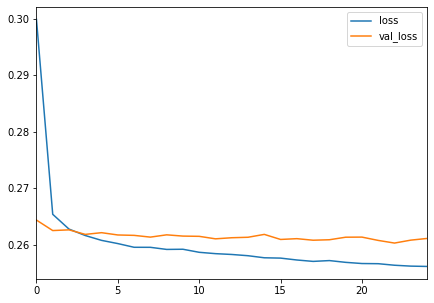

In [137]:
print(nn_result)
print(nn_cm)
losses.plot()

In [138]:
nn_cm_rus, nn_result_rus,losses_rus= neural_network(X_train_rus,y_train_rus,X_test,y_test)

Train on 123730 samples, validate on 79044 samples
Epoch 1/25
123730/123730 [==============================] - 2s 18us/sample - loss: 0.4397 - val_loss: 0.3549
Epoch 2/25
123730/123730 [==============================] - 2s 16us/sample - loss: 0.3713 - val_loss: 0.3521
Epoch 3/25
123730/123730 [==============================] - 2s 16us/sample - loss: 0.3658 - val_loss: 0.3702
Epoch 4/25
123730/123730 [==============================] - 2s 14us/sample - loss: 0.3633 - val_loss: 0.3578
Epoch 5/25
123730/123730 [==============================] - 2s 14us/sample - loss: 0.3619 - val_loss: 0.3655
Epoch 6/25
123730/123730 [==============================] - 2s 14us/sample - loss: 0.3606 - val_loss: 0.3671
Epoch 7/25
123730/123730 [==============================] - 2s 17us/sample - loss: 0.3597 - val_loss: 0.3605
Epoch 8/25
123730/123730 [==============================] - 2s 14us/sample - loss: 0.3594 - val_loss: 0.3606
Epoch 9/25
123730/123730 [==============================] - 2s 14us/sample - 

{'f1-score': 0.6, 'accuracy': 0.78}
[[12902  2756]
 [14500 48886]]


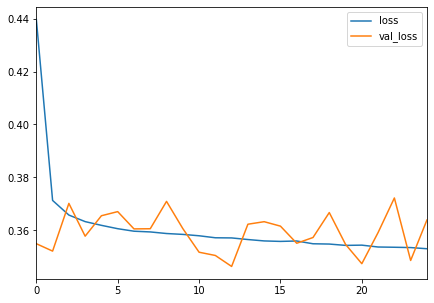

In [139]:
print(nn_result_rus)
print(nn_cm_rus)
losses_rus.plot()

In [140]:
nn_cm_ros, nn_result_ros,losses_ros= neural_network(X_ros,y_ros,X_test,y_test)

Train on 508620 samples, validate on 79044 samples
Epoch 1/25
508620/508620 [==============================] - 6s 13us/sample - loss: 0.3863 - val_loss: 0.3443
Epoch 2/25
508620/508620 [==============================] - 6s 11us/sample - loss: 0.3621 - val_loss: 0.3654
Epoch 3/25
508620/508620 [==============================] - 5s 11us/sample - loss: 0.3599 - val_loss: 0.3541
Epoch 4/25
508620/508620 [==============================] - 6s 11us/sample - loss: 0.3586 - val_loss: 0.3552
Epoch 5/25
508620/508620 [==============================] - 7s 13us/sample - loss: 0.3578 - val_loss: 0.3653
Epoch 6/25
508620/508620 [==============================] - 7s 14us/sample - loss: 0.3569 - val_loss: 0.3558
Epoch 7/25
508620/508620 [==============================] - 8s 15us/sample - loss: 0.3561 - val_loss: 0.3510
Epoch 8/25
508620/508620 [==============================] - 7s 15us/sample - loss: 0.3553 - val_loss: 0.3524
Epoch 9/25
508620/508620 [==============================] - 5s 11us/sample - 

{'f1-score': 0.61, 'accuracy': 0.8}
[[12459  3199]
 [12465 50921]]


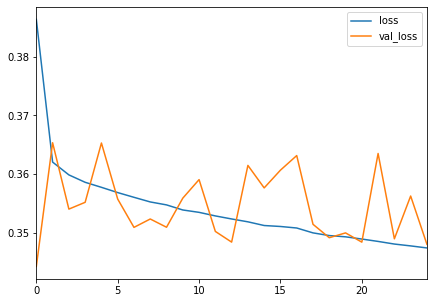

In [141]:
print(nn_result_ros)
print(nn_cm_ros)
losses_ros.plot()

In [142]:
nn_cm_sm, nn_result_sm,losses_sm= neural_network(X_train_sm,y_train_sm,X_test,y_test)

Train on 508620 samples, validate on 79044 samples
Epoch 1/25
508620/508620 [==============================] - 7s 14us/sample - loss: 0.2253 - val_loss: 0.2777
Epoch 2/25
508620/508620 [==============================] - 7s 13us/sample - loss: 0.1906 - val_loss: 0.2784
Epoch 3/25
508620/508620 [==============================] - 7s 15us/sample - loss: 0.1870 - val_loss: 0.2721
Epoch 4/25
508620/508620 [==============================] - 6s 12us/sample - loss: 0.1852 - val_loss: 0.2715
Epoch 5/25
508620/508620 [==============================] - 6s 12us/sample - loss: 0.1843 - val_loss: 0.2707
Epoch 6/25
508620/508620 [==============================] - 6s 11us/sample - loss: 0.1834 - val_loss: 0.2722
Epoch 7/25
508620/508620 [==============================] - 9s 18us/sample - loss: 0.1829 - val_loss: 0.2722
Epoch 8/25
508620/508620 [==============================] - 9s 17us/sample - loss: 0.1823 - val_loss: 0.2709
Epoch 9/25
508620/508620 [==============================] - 8s 16us/sample - 

{'f1-score': 0.6, 'accuracy': 0.89}
[[ 6760  8898]
 [  105 63281]]


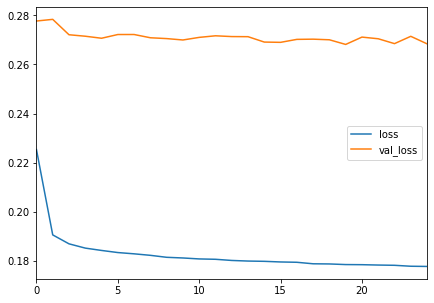

In [143]:
print(nn_result_sm)
print(nn_cm_sm)
losses_sm.plot()

In [144]:
nn_cm_smt, nn_result_smt,losses_smt= neural_network(X_train_smt,y_train_smt,X_test,y_test)

Train on 466694 samples, validate on 79044 samples
Epoch 1/25
466694/466694 [==============================] - 6s 12us/sample - loss: 0.2193 - val_loss: 0.2774
Epoch 2/25
466694/466694 [==============================] - 6s 12us/sample - loss: 0.1864 - val_loss: 0.2750
Epoch 3/25
466694/466694 [==============================] - 6s 12us/sample - loss: 0.1826 - val_loss: 0.2732
Epoch 4/25
466694/466694 [==============================] - 5s 11us/sample - loss: 0.1812 - val_loss: 0.2741
Epoch 5/25
466694/466694 [==============================] - 5s 11us/sample - loss: 0.1798 - val_loss: 0.2738
Epoch 6/25
466694/466694 [==============================] - 8s 18us/sample - loss: 0.1791 - val_loss: 0.2714
Epoch 7/25
466694/466694 [==============================] - 6s 12us/sample - loss: 0.1782 - val_loss: 0.2745
Epoch 8/25
466694/466694 [==============================] - 6s 13us/sample - loss: 0.1775 - val_loss: 0.2713
Epoch 9/25
466694/466694 [==============================] - 6s 13us/sample - 

{'f1-score': 0.6, 'accuracy': 0.89}
[[ 6754  8904]
 [  120 63266]]


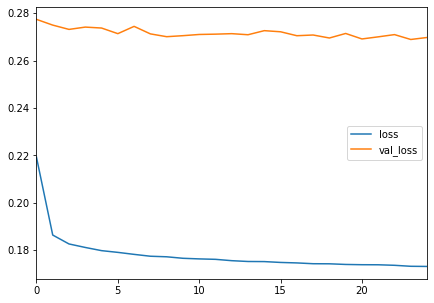

In [145]:
print(nn_result_smt)
print(nn_cm_smt)
losses_smt.plot()

In [146]:
prediction_data={'Model':['Logistic Regression', 'Logistic Regression Random Under_Sample','Logistic Regression Random Over_Sample',
                          'Logistic Regression SMOTE','Logistic Regression SMOTE & Tomek links',
                          
                          'Decision Tree','Decision tree Random Under_Sample','Decision Tree Random Over_Sample',
                          'Decision Tree SMOTE','Decision Tree SMOTE & Tomek links',
                          
                          'Random Forest','Random Forest Random Under_Sample','Random Forest Random Over_Sample',
                          'Random Forest SMOTE','Random Forest SMOTE & Tomek links',
                          
                          'NN','NN Random Under_Sample','NN Random Over_Sample',
                          'NN SMOTE','NN SMOTE & Tomek links'
                         ],
                   'F1-score':[lr_result['f1-score'],lr_result_rus['f1-score'],lr_result_ros['f1-score'],
                               lr_result_sm['f1-score'],lr_result_smt['f1-score'],
                              dtree_result['f1-score'],dtree_result_rus['f1-score'],dtree_result_ros['f1-score'],
                               dtree_result_sm['f1-score'],dtree_result_smt['f1-score'],
                              rf_result['f1-score'],rf_result_rus['f1-score'],rf_result_ros['f1-score'],
                               rf_result_sm['f1-score'],rf_result_smt['f1-score'],
                              nn_result['f1-score'],nn_result_rus['f1-score'],nn_result_ros['f1-score'],
                               nn_result_sm['f1-score'],nn_result_smt['f1-score']],
                 
                   'Accuracy':[lr_result['accuracy'],lr_result_rus['accuracy'],lr_result_ros['accuracy'],
                               lr_result_sm['accuracy'],lr_result_smt['accuracy'],
                              dtree_result['accuracy'],dtree_result_rus['accuracy'],dtree_result_ros['accuracy'],
                               dtree_result_sm['accuracy'],dtree_result_smt['accuracy'],
                              rf_result['accuracy'],rf_result_rus['accuracy'],rf_result_ros['accuracy'],
                               rf_result_sm['accuracy'],rf_result_smt['accuracy'],
                              nn_result['accuracy'],nn_result_rus['accuracy'],nn_result_ros['accuracy'],
                               nn_result_sm['accuracy'],nn_result_smt['accuracy']]
                    }
 
# Create DataFrame
prediction_table = pd.DataFrame(prediction_data)
prediction_table

,Model,F1-score,Accuracy
0,Logistic Regression,0.10,0.80
1,Logistic Regression Random Under_Sample,0.41,0.64
2,Logistic Regression Random Over_Sample,0.37,0.61
3,Logistic Regression SMOTE,0.37,0.59
4,Logistic Regression SMOTE & Tomek links,0.41,0.65
5,Decision Tree,0.58,0.83
6,Decision tree Random Under_Sample,0.54,0.74
7,Decision Tree Random Over_Sample,0.58,0.83
8,Decision Tree SMOTE,0.57,0.82
9,Decision Tree SMOTE & Tomek links,0.57,0.82


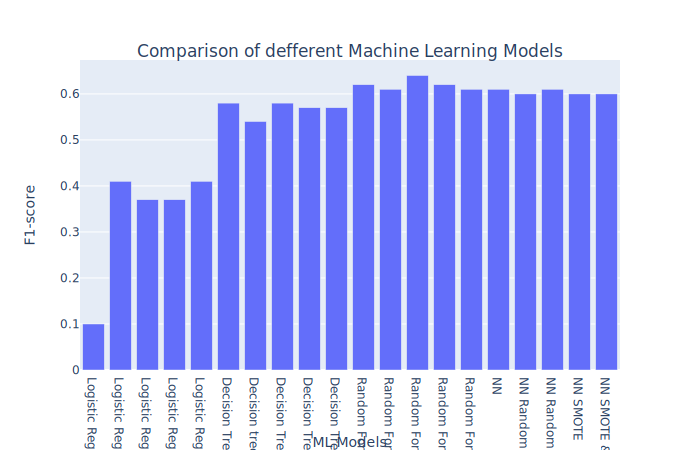

In [147]:
fig = px.bar(x=prediction_table['Model'], y=prediction_table['F1-score'])
fig.update_layout( title={
        'text': "Comparison of defferent Machine Learning Models",
        'y':0.9,'x':0.5,'xanchor': 'center','yanchor': 'top'},
    xaxis_title="ML Models",
    yaxis_title="F1-score")

fig.show(renderer='svg')

# Resource:

The Data : Subset of the LendingClub DataSet from Kaggle provide by: Copyright by Pierian Data Inc., Jose Marcial Portilla.
https://www.kaggle.com/wordsforthewise/lending-club 

https://www.kaggle.com/rafjaa/resampling-strategies-for-imbalanced-datasets

https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/